# Milestone 3 – Population size and FIFA World Cup success (1966–2014)

## Research question
**Is there a relationship between a country's population size and its World Cup success?**

### Operationalization of success (two variants)
1) **Podium (binary, main analysis):** In a given World Cup year, a country is successful if it finishes **1st / 2nd / 3rd**.
2) **Weighted success (secondary):** `3` points for **1st**, `2` for **2nd**, `1` for **3rd** in a given year.

## Data used (from Milestone 2)
- `worldcups_population_merged.csv` (World Cup years + podium countries + ISO3 codes)
- `world_population.csv` (country list + population for benchmark years: 1970, 1980, 1990, 2000, 2010, 2015, 2020, 2022)

## Important note on year-specific population
`world_population.csv` does **not** contain every single year. It contains population for specific benchmark years.
For World Cup years like **1974** or **1994**, we therefore estimate population by **log-linear interpolation** between the two nearest benchmark years.
For **1966** (before 1970), we use **log-linear extrapolation** based on 1970–1980.


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt


## 1) Load data

In [2]:
cups = pd.read_csv("worldcups_population_merged.csv")
wp = pd.read_csv("world_population.csv")

print("cups rows:", len(cups), "| columns:", len(cups.columns))
print("wp rows:", len(wp), "| columns:", len(wp.columns))
cups.head()


cups rows: 13 | columns: 16
wp rows: 234 | columns: 17


,Year,Country,Winner,Runners-Up,Third,Fourth,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance,Winner_iso3,RunnersUp_iso3,Third_iso3,Winner_population,RunnersUp_population,Third_population
0,1966,England,England,Germany,Portugal,Soviet Union,89,16,32,1.563.135,GBR,DEU,PRT,54648500.0,76600311,8930990
1,1970,Mexico,Brazil,Italy,Germany,Uruguay,95,16,32,1.603.975,BRA,ITA,DEU,95375651.0,53821850,78169289
2,1974,Germany,Germany,Netherlands,Poland,Brazil,97,16,38,1.865.753,DEU,NLD,POL,78967433.0,13545056,33678899
3,1978,Argentina,Argentina,Netherlands,Brazil,Italy,102,16,38,1.545.791,ARG,NLD,BRA,27132158.0,13941700,115600942
4,1982,Spain,Italy,Germany,Poland,France,146,24,52,2.109.723,ITA,DEU,POL,56543548.0,78333366,36230481


In [3]:
# Check required columns exist (fail fast, no guessing)
required_cups = {"Year","Winner_iso3","RunnersUp_iso3","Third_iso3"}
missing = required_cups - set(cups.columns)
if missing:
    raise ValueError(f"Missing required columns in worldcups_population_merged.csv: {missing}")

required_wp = {"CCA3","Country/Territory","1970 Population","1980 Population","1990 Population","2000 Population","2010 Population","2015 Population","2020 Population","2022 Population"}
missing_wp = required_wp - set(wp.columns)
if missing_wp:
    raise ValueError(f"Missing required columns in world_population.csv: {missing_wp}")

"OK"


'OK'

## 2) Build a country-year panel (all countries × each World Cup year)
We create one row per **(country, World Cup year)**.
Each row gets:
- estimated population in that year
- `podium` (0/1)
- `weighted_success` (0/1/2/3)


In [4]:
# World Cup years present in the dataset (your chosen scope: whatever is in this file)
wm_years = sorted(cups["Year"].dropna().astype(int).unique().tolist())
wm_years[:10], wm_years[-10:], len(wm_years)


([1966, 1970, 1974, 1978, 1982, 1986, 1990, 1994, 1998, 2002],
 [1978, 1982, 1986, 1990, 1994, 1998, 2002, 2006, 2010, 2014],
 13)

In [5]:
# Build a clean country table from world_population.csv
countries = wp[["CCA3","Country/Territory"]].rename(columns={"CCA3":"iso3","Country/Territory":"country"}).copy()
countries = countries.dropna(subset=["iso3"]).drop_duplicates(subset=["iso3"])
countries.head(), len(countries)


(  iso3         country
 0  AFG     Afghanistan
 1  ALB         Albania
 2  DZA         Algeria
 3  ASM  American Samoa
 4  AND         Andorra,
 234)

### 2.1 Year-specific population via log-linear interpolation
Reason: populations grow roughly exponentially; interpolating on the log scale is more realistic than linear interpolation on raw counts.


In [6]:
# Prepare population data in long format for interpolation
pop_year_cols = ["1970 Population","1980 Population","1990 Population","2000 Population","2010 Population","2015 Population","2020 Population","2022 Population"]
pop_years = np.array([int(c.split()[0]) for c in pop_year_cols])

pop_long = wp[["CCA3"] + pop_year_cols].rename(columns={"CCA3":"iso3"}).copy()

# Ensure numeric
for c in pop_year_cols:
    pop_long[c] = pd.to_numeric(pop_long[c], errors="coerce")

def estimate_population(iso3: str, year: int) -> float:
    row = pop_long.loc[pop_long["iso3"] == iso3]
    if row.empty:
        return np.nan
    vals = row.iloc[0][pop_year_cols].to_numpy(dtype=float)

    # Need at least two points for interpolation/extrapolation
    mask = ~np.isnan(vals) & (vals > 0)
    if mask.sum() < 2:
        return np.nan

    ys = pop_years[mask]
    ps = vals[mask]

    # Work in log space
    logp = np.log(ps)

    # If year exactly available:
    if year in ys:
        return float(ps[np.where(ys == year)][0])

    # If year within range -> interpolate
    if year > ys.min() and year < ys.max():
        # find neighbors
        y1 = ys[ys < year].max()
        y2 = ys[ys > year].min()
        p1 = logp[np.where(ys == y1)][0]
        p2 = logp[np.where(ys == y2)][0]
        # linear interpolation in log space
        w = (year - y1) / (y2 - y1)
        return float(np.exp(p1 + w*(p2 - p1)))

    # If outside range -> extrapolate using nearest two points
    # For 1966 in your scope, this uses 1970–1980 if available
    if year <= ys.min():
        y1, y2 = ys[0], ys[1]
    else:
        y1, y2 = ys[-2], ys[-1]
    p1 = logp[np.where(ys == y1)][0]
    p2 = logp[np.where(ys == y2)][0]
    slope = (p2 - p1) / (y2 - y1)
    return float(np.exp(p1 + slope*(year - y1)))

# Quick check on one known iso3 from cups
sample_iso3 = cups.loc[0, "Winner_iso3"]
for y in [1966, 1970, 1974, 2014]:
    print(sample_iso3, y, estimate_population(sample_iso3, y))


GBR 1966 55381979.414302796
GBR 1970 55650166.0
GBR 1974 55919651.27609277
GBR 2014 64723876.92151736


In [7]:
# Create the country-year panel
panel = countries.assign(key=1).merge(pd.DataFrame({"Year": wm_years, "key": 1}), on="key").drop(columns=["key"])

# Estimate population for each (iso3, Year)
panel["population_est"] = panel.apply(lambda r: estimate_population(r["iso3"], int(r["Year"])), axis=1)

# Drop rows where we cannot estimate population
panel = panel.dropna(subset=["population_est"])
panel = panel[panel["population_est"] > 0].copy()

# Log-transform for analysis
panel["log_pop"] = np.log10(panel["population_est"])

panel.head(), len(panel)


(  iso3      country  Year  population_est   log_pop
 0  AFG  Afghanistan  1966    1.012889e+07  7.005562
 1  AFG  Afghanistan  1970    1.075297e+07  7.031528
 2  AFG  Afghanistan  1974    1.141551e+07  7.057495
 3  AFG  Afghanistan  1978    1.211886e+07  7.083462
 4  AFG  Afghanistan  1982    1.210572e+07  7.082991,
 3042)

## 3) Add success labels (podium & weighted) per World Cup year

In [8]:
# Build a lookup table for podium finishers per year
pod = pd.concat([
    cups[["Year","Winner_iso3"]].rename(columns={"Winner_iso3":"iso3"}).assign(podium=1, weighted_success=3),
    cups[["Year","RunnersUp_iso3"]].rename(columns={"RunnersUp_iso3":"iso3"}).assign(podium=1, weighted_success=2),
    cups[["Year","Third_iso3"]].rename(columns={"Third_iso3":"iso3"}).assign(podium=1, weighted_success=1),
], ignore_index=True)

# Merge success into panel; non-matches = 0 success
panel = panel.merge(pod, on=["Year","iso3"], how="left")
panel["podium"] = panel["podium"].fillna(0).astype(int)
panel["weighted_success"] = panel["weighted_success"].fillna(0).astype(int)

panel.head()


,iso3,country,Year,population_est,log_pop,podium,weighted_success
0,AFG,Afghanistan,1966,1.012889e+07,7.005562,0,0
1,AFG,Afghanistan,1970,1.075297e+07,7.031528,0,0
2,AFG,Afghanistan,1974,1.141551e+07,7.057495,0,0
3,AFG,Afghanistan,1978,1.211886e+07,7.083462,0,0
4,AFG,Afghanistan,1982,1.210572e+07,7.082991,0,0


In [9]:
# Sanity check: exactly 3 podium countries per year (if no duplicates)
podiums_per_year = panel.groupby("Year")["podium"].sum().sort_index()
podiums_per_year.head(10), podiums_per_year.tail(10)


(Year
 1966    3
 1970    3
 1974    3
 1978    3
 1982    3
 1986    3
 1990    3
 1994    3
 1998    3
 2002    3
 Name: podium, dtype: int64,
 Year
 1978    3
 1982    3
 1986    3
 1990    3
 1994    3
 1998    3
 2002    3
 2006    3
 2010    3
 2014    3
 Name: podium, dtype: int64)

## 4) Exploratory plots (for poster)

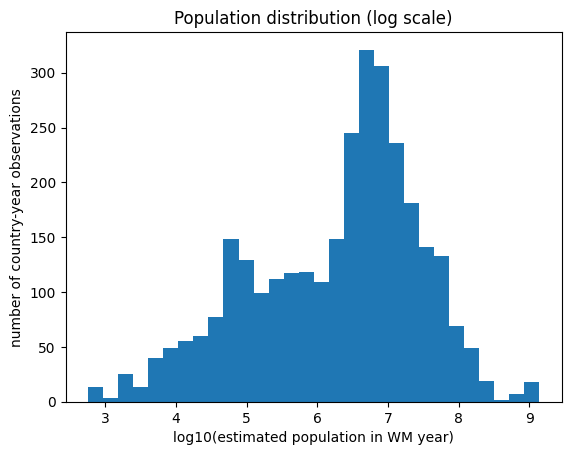

In [10]:
# Distribution of log population
plt.figure()
plt.hist(panel["log_pop"], bins=30)
plt.xlabel("log10(estimated population in WM year)")
plt.ylabel("number of country-year observations")
plt.title("Population distribution (log scale)")
plt.show()


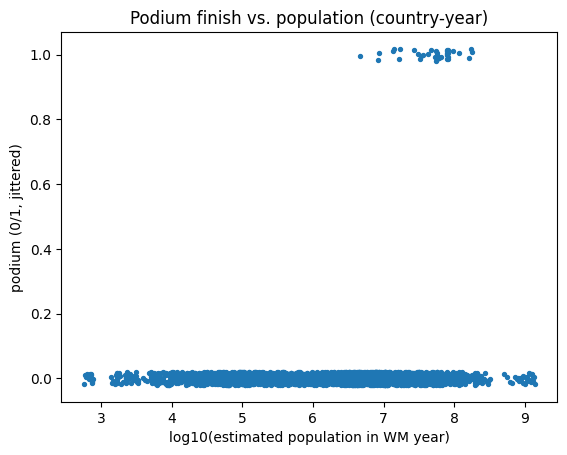

In [11]:
# Podium vs. log population (scatter: many points -> we show jitter on y for readability)
plt.figure()
y = panel["podium"] + np.random.uniform(-0.02, 0.02, size=len(panel))
plt.scatter(panel["log_pop"], y, s=8)
plt.xlabel("log10(estimated population in WM year)")
plt.ylabel("podium (0/1, jittered)")
plt.title("Podium finish vs. population (country-year)")
plt.show()


## 5) Hypothesis test (main analysis)
### Hypotheses
- **H0:** mean(log_pop) is equal for podium vs. non-podium country-year observations.
- **H1:** mean(log_pop) differs between the two groups.
- Significance level **α = 0.05**.

We use **Welch's t-test** (unequal variances), because group sizes and variances differ.


In [12]:
alpha = 0.05
g_podium = panel.loc[panel["podium"] == 1, "log_pop"]
g_non = panel.loc[panel["podium"] == 0, "log_pop"]

print("Group sizes:")
print("  podium == 1:", len(g_podium))
print("  podium == 0:", len(g_non))

t_stat, p_value = ttest_ind(g_podium, g_non, equal_var=False, nan_policy="omit")

print("\nWelch t-test (log10 population):")
print(f"  t = {t_stat:.4f}")
print(f"  p = {p_value:.6g}")
print(f"  alpha = {alpha}")


Group sizes:
  podium == 1: 39
  podium == 0: 3003

Welch t-test (log10 population):
  t = 22.9222
  p = 7.44158e-28
  alpha = 0.05


In [13]:
def cohens_d(x, y):
    x = np.asarray(x); y = np.asarray(y)
    x = x[~np.isnan(x)]; y = y[~np.isnan(y)]
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    pooled_std = np.sqrt(((nx - 1)*x.std(ddof=1)**2 + (ny - 1)*y.std(ddof=1)**2) / (nx + ny - 2))
    if pooled_std == 0:
        return np.nan
    return (x.mean() - y.mean()) / pooled_std

d = cohens_d(g_podium, g_non)

print("Means:")
print(f"  mean(log_pop) podium=1: {g_podium.mean():.4f}")
print(f"  mean(log_pop) podium=0: {g_non.mean():.4f}")
print(f"\nEffect size (Cohen's d): {d:.4f}")


Means:
  mean(log_pop) podium=1: 7.6776
  mean(log_pop) podium=0: 6.2513

Effect size (Cohen's d): 1.2157


In [14]:
decision = "REJECT H0" if p_value <= alpha else "FAIL TO REJECT H0"
direction = "higher" if g_podium.mean() > g_non.mean() else "lower"

print("Decision:", decision)
print(f"Interpretation (template): Countries with a podium finish have {direction} mean population (log-scale) than non-podium countries in World Cup years.")


Decision: REJECT H0
Interpretation (template): Countries with a podium finish have higher mean population (log-scale) than non-podium countries in World Cup years.


## 6) Secondary analysis: weighted success
This is descriptive (poster-friendly). We show the relationship between population and the weighted success score.


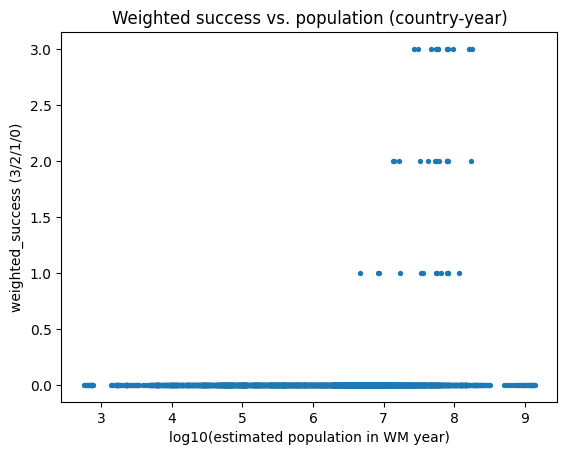

Pearson correlation (log_pop vs weighted_success): 0.1298


In [15]:
plt.figure()
plt.scatter(panel["log_pop"], panel["weighted_success"], s=8)
plt.xlabel("log10(estimated population in WM year)")
plt.ylabel("weighted_success (3/2/1/0)")
plt.title("Weighted success vs. population (country-year)")
plt.show()

corr = np.corrcoef(panel["log_pop"], panel["weighted_success"])[0,1]
print(f"Pearson correlation (log_pop vs weighted_success): {corr:.4f}")


## 7) Limitations (kept minimal and directly tied to data)
- Population values for non-benchmark years are **estimated** via log-linear interpolation/extrapolation because the population file provides only specific years.
- This study shows **association**, not causation (many confounders like GDP, football infrastructure, etc. are not modeled).
